# Natural Language Processing Demystified | Seq2Seq and Attention
https://nlpdemystified.org<br>
https://github.com/futuremojo/nlp-demystified<br><br>

Course module for this demo: https://www.nlpdemystified.org/course/seq2seq-and-attention

**IMPORTANT**<br>
Enable **GPU acceleration** by going to *Runtime > Change Runtime Type*. Keep in mind that, on certain tiers, you're not guaranteed GPU access depending on usage history and current load.
<br><br>
Also, if you're running this in the cloud rather than a local Jupyter server on your machine, then the notebook will *timeout* after a period of inactivity.
<br><br>
Refer to this link on how to run Colab notebooks locally on your machine to avoid this issue:<br>
https://research.google.com/colaboratory/local-runtimes.html

In [1]:
import io
import json
import numpy as np
import pandas as pd
import random
import re
import tensorflow as tf
import unicodedata

#from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Recurrence-based Seq2Seq Neural Machine Translation **WITHOUT** Attention

Our first model will use just two LSTMs (one encoder and one decoder) to translate Hungarian to English. We're going with Hungarian here because it's a particularly challenging language to tackle with few resources.
<br><br>
The dataset we'll use comes from **Tatoeba**, a collection of sentence translations in a variety of languages sourced from volunteers:
<br>
https://tatoeba.org/en

The **NLP Demystified** repo has a lightly processed copy that's already been split into train/validation/test sets and pre-shuffled.

In [2]:
!wget https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt
# Download the training set.

--2024-01-21 13:31:12--  https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5518306 (5.3M) [text/plain]
Saving to: ‘hun_eng_pairs_train.txt.5’

hun_eng_pairs_train 100%[===================>]   5.26M  4.71MB/s    in 1.1s    

2024-01-21 13:31:13 (4.71 MB/s) - ‘hun_eng_pairs_train.txt.5’ saved [5518306/5518306]



In [3]:
with open('hun_eng_pairs_train.txt') as file:
  train = [line.rstrip() for line in file]

Each entry consists of a Hungarian sentence followed by its English translation, separated by a **\<sep\>** delimiter

In [4]:
train[:3]

["Teszek rá, mit mondasz!<sep>I don't care what you say.",
 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.<sep>We need more people like you on our team.',
 'Vigyázz a gyerekeimre!<sep>Take care of my children.']

This is a relatively tiny dataset for neural machine translation, but we'll see how far we can get.

In [5]:
len(train)

88647

In [6]:
# Separate the input (Hungarian) and target (English) sentences into separate lists.
SEPARATOR = '<sep>'
train_input, train_target = map(list, zip(*[pair.split(SEPARATOR) for pair in train]))

In [7]:
print(train_input[:3])
print(train_target[:3])

['Teszek rá, mit mondasz!', 'Több olyan ember kell nekünk a csapatba, mint amilyen te vagy.', 'Vigyázz a gyerekeimre!']
["I don't care what you say.", 'We need more people like you on our team.', 'Take care of my children.']


Since we're dealing with a source language that uses accented characters, it's important to apply *Unicode normalization*
<br><br>
In the example below, two different sets of Unicode yield the same character visually. The first Unicode is for an accented 'a', while the second Unicode combines an 'a' with an accent mark.

In [8]:
print("\u00E1", "\u0061\u0301")

á á


Though these characters look the same to us reading them, they'll be treated differently by a model. So to avoid this, the following function normalizes any accented characters into the same set of Unicode, and then replaces them with their ASCII equivalents.<br>
https://docs.python.org/3/library/unicodedata.html
<br><br>
Here's an informative article on the importance of Unicode normalization and how to go about it (including what _NFD_ means):<br>
https://towardsdatascience.com/what-on-earth-is-unicode-normalization-56c005c55ad0

In [9]:
# Unicode normalization
def normalize_unicode(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn') # Non-spacing marks

We're building a **word**-based translation model, but we still want to keep punctuation and treat them as separate tokens, so we'll insert a space between any relevant punctuation and the characters around them. This way, our tokenizer (which won't filter out punctuation) will output punctuation marks as separate tokens.

This function does that and unicode normalization.

In [10]:
def preprocess_sentence(s):
  s = normalize_unicode(s)
  s = re.sub(r"([?.!,¿])", r" \1 ", s) # Add spaces around punctuation
  s = re.sub(r'[" "]+', " ", s)      # Replace multiple spaces with a single space
  s = s.strip()
  return s

In [11]:
# Preprocess both the source and target sentences.
train_preprocessed_input = [preprocess_sentence(s) for s in train_input]
train_preprocessed_target = [preprocess_sentence(s) for s in train_target]

After preprocessing, the unicode should be normalized and there should be spaces on either side of any punctuation.

In [12]:
train_preprocessed_input[:3]

['Teszek ra , mit mondasz !',
 'Tobb olyan ember kell nekunk a csapatba , mint amilyen te vagy .',
 'Vigyazz a gyerekeimre !']

Like the language model we built in the [previous demo](https://github.com/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_recurrent_neural_networks.ipynb), we'll use **Teacher Forcing** with our translation model (specifically, the decoder). This begins by placing a  start-of-sentence tag (_\<sos\>_) and end-of-sentence tag (_\<eos\>_) at the beginning and end of each target sentence, respectively.

In [13]:
def tag_target_sentences(sentences):
  tagged_sentences = map(lambda s: (' ').join(['<sos>', s, '<eos>']), sentences)
  return list(tagged_sentences)

In [14]:
train_tagged_preprocessed_target = tag_target_sentences(train_preprocessed_target)

In [15]:
train_tagged_preprocessed_target[:3]

["<sos> I don't care what you say . <eos>",
 '<sos> We need more people like you on our team . <eos>',
 '<sos> Take care of my children . <eos>']

Next, we'll tokenize our input and target sentences, taking care to keep relevant punctuation.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br><br>
Note that we're also including an out-of-vocabulary token (_\<unk\>_) in the tokenizer initialization. At inference time, if the tokenizer encounters a word it didn't see during the initial fit on the training data, that word will be replaced with _\<unk\>_ and the translation system will need to cope with it.

In [16]:
# Tokenizer for the Hungarian input sentences. Note how we're not filtering punctuation.
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
source_tokenizer.fit_on_texts(train_preprocessed_input)
source_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 88647,
 'word_counts': '{"teszek": 28, "ra": 440, ",": 18083, "mit": 1494, "mondasz": 37, "!": 5817, "tobb": 266, "olyan": 737, "ember": 282, "kell": 2251, "nekunk": 267, "a": 24987, "csapatba": 4, "mint": 988, "amilyen": 23, "te": 993, "vagy": 1642, ".": 68274, "vigyazz": 39, "gyerekeimre": 3, "miert": 1668, "van": 5268, "szuksege": 134, "onoknek": 27, "ket": 443, "kerekparra": 25, "?": 15270, "nincs": 1243, "helye": 4, "ketsegnek": 2, "mary": 560, "benyult": 7, "az": 8383, "erszenyebe": 1, "es": 1543, "elovett": 6, "egy": 5808, "fenykepet": 12, "sok": 683, "butor": 8, "volt": 3040, "szobaban": 72, "tarstalan": 1, "vagyok": 2076, "en": 1352, "is": 1103, "remelem": 296, "mikor": 700, "ert": 85, "veget": 44, "ezt": 2294, "bicot": 24, "meg": 4966, "vetted": 101, "lathatom": 7, "tom": 10857, "kuzdott": 5, "adnal": 4, "nekem": 1418

In [17]:
source_vocab_size = len(source_tokenizer.word_index) + 1
print(source_vocab_size)

38539


In [18]:
# Tokenizer for the English target sentences.
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(train_tagged_preprocessed_target)
target_tokenizer.get_config()

{'num_words': None,
 'filters': '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '<unk>',
 'document_count': 88647,
 'word_counts': '{"<sos>": 88647, "i": 19473, "don\'t": 4041, "care": 217, "what": 3414, "you": 16070, "say": 507, ".": 73314, "<eos>": 88647, "we": 3700, "need": 1407, "more": 671, "people": 531, "like": 2543, "on": 2426, "our": 550, "team": 66, "take": 799, "of": 4600, "my": 3969, "children": 325, "why": 1767, "do": 5407, "two": 526, "bicycles": 121, "?": 15204, "there\'s": 497, "no": 1269, "room": 426, "for": 3071, "doubt": 53, "mary": 1767, "reached": 43, "into": 351, "her": 868, "purse": 17, "and": 1734, "took": 331, "out": 1073, "a": 11379, "photo": 14, "there": 1550, "was": 4470, "lot": 561, "furniture": 19, "in": 4576, "the": 14579, "i\'m": 3674, "lonely": 25, "hope": 392, "so": 907, ",": 3644, "too": 786, "when": 1061, "did": 2141, "it": 5384, "end": 89, "buy": 625, "this": 4898, "bicycle": 672, "can": 2263, "se

In [19]:
target_vocab_size = len(target_tokenizer.word_index) + 1
print(target_vocab_size)

10556


Next, we'll vectorize the input and target sentences just like we did in the last few demos.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences

In [20]:
train_encoder_inputs = source_tokenizer.texts_to_sequences(train_preprocessed_input)

In [21]:
print(train_encoder_inputs[:3])
print(source_tokenizer.sequences_to_texts(train_encoder_inputs[:3]))

[[1395, 91, 4, 27, 1080, 10], [153, 56, 145, 17, 152, 3, 7232, 4, 45, 1670, 44, 23, 2], [1026, 3, 8933, 10]]
['teszek ra , mit mondasz !', 'tobb olyan ember kell nekunk a csapatba , mint amilyen te vagy .', 'vigyazz a gyerekeimre !']


For teacher forcing, we'll create two copies of each vectorized **target** sentence, with the second copy shifted over by one.

The function below takes a collection of sentences, vectorizes them, then returns two copies of each. The first will include every token except the last, the second will include every token except the first.

In [22]:
def generate_decoder_inputs_targets(sentences, tokenizer):
  seqs = tokenizer.texts_to_sequences(sentences)
  decoder_inputs = [s[:-1] for s in seqs] # Drop the last token in the sentence.
  decoder_targets = [s[1:] for s in seqs] # Drop the first token in the sentence.

  return decoder_inputs, decoder_targets

In [23]:
train_decoder_inputs, train_decoder_targets = generate_decoder_inputs_targets(train_tagged_preprocessed_target,
                                                                              target_tokenizer)

Each token of a *decoder_input* sentence will be fed to the decoder as the **next** expected token, and each token of a *decoder_target* sentence will be used to calculate the loss against the decoder's actual output; exactly as we covered in the slides.

In [24]:
print(train_decoder_inputs[0], train_decoder_targets[0])

print(target_tokenizer.sequences_to_texts(train_decoder_inputs[:1]),
      target_tokenizer.sequences_to_texts(train_decoder_targets[:1]))

[2, 5, 23, 306, 28, 7, 151, 4] [5, 23, 306, 28, 7, 151, 4, 3]
["<sos> i don't care what you say ."] ["i don't care what you say . <eos>"]


Exactly as we did in the previous [RNN demo](https://github.com/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_recurrent_neural_networks.ipynb), we'll pad all sequences to a uniform length.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

In [25]:
max_encoding_len = len(max(train_encoder_inputs, key=len))
max_encoding_len

37

In [26]:
max_decoding_len = len(max(train_decoder_inputs, key=len))
max_decoding_len

34

In [27]:
len(max(train_decoder_targets, key=len))

34

In [28]:
padded_train_encoder_inputs = pad_sequences(train_encoder_inputs, max_encoding_len, padding='post', truncating='post')
padded_train_decoder_inputs = pad_sequences(train_decoder_inputs, max_decoding_len, padding='post', truncating='post')
padded_train_decoder_targets = pad_sequences(train_decoder_targets, max_decoding_len, padding='post', truncating='post')

In [29]:
print(padded_train_encoder_inputs[0])
print(padded_train_decoder_inputs[0])
print(padded_train_decoder_targets[0])

[1395   91    4   27 1080   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
[  2   5  23 306  28   7 151   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5  23 306  28   7 151   4   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


When converting a padded sequence back to text, padding is replaced with the out-of-vocabulary *\<unk\>* token.

In [30]:
target_tokenizer.sequences_to_texts([padded_train_decoder_inputs[0]])

["<sos> i don't care what you say . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>"]

The training dataset is now ready, and we can follow the same preprocessing steps to prepare the validation dataset.

In [31]:
# Download validation set pairs.
!wget https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt

--2024-01-21 13:31:17--  https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_val.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646226 (631K) [text/plain]
Saving to: ‘hun_eng_pairs_val.txt.4’

hun_eng_pairs_val.t 100%[===================>] 631.08K  --.-KB/s    in 0.1s    

2024-01-21 13:31:18 (6.20 MB/s) - ‘hun_eng_pairs_val.txt.4’ saved [646226/646226]



In [32]:
with open('hun_eng_pairs_val.txt') as file:
  val = [line.rstrip() for line in file]

In [33]:
def process_dataset(dataset):

  # Split the Hungarian and English sentences into separate lists.
  input, output = map(list, zip(*[pair.split(SEPARATOR) for pair in dataset]))

  # Unicode normalization and inserting spaces around punctuation.
  preprocessed_input = [preprocess_sentence(s) for s in input]
  preprocessed_output = [preprocess_sentence(s) for s in output]

  # Tag target sentences with <sos> and <eos> tokens.
  tagged_preprocessed_output = tag_target_sentences(preprocessed_output)

  # Vectorize encoder source sentences.
  encoder_inputs = source_tokenizer.texts_to_sequences(preprocessed_input)

  # Vectorize and create decoder input and target sentences.
  decoder_inputs, decoder_targets = generate_decoder_inputs_targets(tagged_preprocessed_output,
                                                                    target_tokenizer)

  # Pad all collections.
  padded_encoder_inputs = pad_sequences(encoder_inputs, max_encoding_len, padding='post', truncating='post')
  padded_decoder_inputs = pad_sequences(decoder_inputs, max_decoding_len, padding='post', truncating='post')
  padded_decoder_targets = pad_sequences(decoder_targets, max_decoding_len, padding='post', truncating='post')

  return padded_encoder_inputs, padded_decoder_inputs, padded_decoder_targets


In [34]:
# Process validation dataset
padded_val_encoder_inputs, padded_val_decoder_inputs, padded_val_decoder_targets = process_dataset(val)

We're now ready to build our translation model. These are the parameters we'll use (feel free to try different values).

In [35]:
embedding_dim = 128
hidden_dim = 256
default_dropout=0.2
batch_size = 32
epochs = 30

Unlike the models we've built up to this point, this model will have **two** inputs:<br>
1. The encoder receives the source sentences (Hungarian) and generates the initial state inputs for the decoder.
2. The decoder receives the decoder input sentences (English) for teacher forcing.
<br>

Since that's the case, we won't use the Keras **Sequential API**. Rather, we'll use the **Functional API** which will give us more flexibility in expressing our model layers as graphs. Fortunately, the work remains pretty intuitive as long as we keep in mind what's happening behind the scenes.
<br>

https://keras.io/api/models/sequential/<br>
https://www.tensorflow.org/guide/keras/functional/

The code in the following cell specifies the encoder. If you haven't used the **Functional API** before, the most important thing to realize here is this: Each layer is like a _node_ in a graph. Each time we pass the output of one layer to the next, it creates a link between the two _nodes_ and allows data to flow through. Once the whole training model is built, we'll visualize it for greater clarity.

In [36]:
# The initial encoder input layer which will take in padded sequences. We're specifying
# a shape of None here but you can specify it upfront if you want since we
# know what the max encoding length is.
encoder_inputs = layers.Input(shape=[None], name='encoder_inputs')

# The embedding layer. Similar to what we did in the RNN demo.
encoder_embeddings = layers.Embedding(source_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='encoder_embeddings')

# Passing the input layer output to the embedding layer creates a link between the
# two. Input sequences will now flow into the embedding layer which will output
# a sequence of embeddings.
encoder_embedding_output = encoder_embeddings(encoder_inputs)


# We're not using any kind of attention mechanism in this model, so setting only
# return_state to True is enough. return_sequences remains False.
encoder_lstm = layers.LSTM(hidden_dim,
                           return_state=True,
                           dropout=default_dropout,
                           name='encoder_lstm')

# Passing the embedding layer output to the LSTM layer creates another link.
# IMPORTANT: The LSTM always returns three values. When return_sequences is
# False, encoder_outputs and state_h are the SAME. When return_sequences is
# True, encoder_outputs contains the encoder hidden states from each time step.
#
# Side note: we won't be using encoder_outputs here so that variable can be
# replaced with a _ if preferred.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_output)

# The final hidden and cell/context states from the encoder will be the the
# initial states for the decoder.
encoder_states = (state_h, state_c)

The code for specifying the decoder is similar except for three additions:
1. The LSTM has *return_sequences* set to *True* since we'll need the hidden state outputted at each timestep (similar to our PoS tagger and language model from the [RNN demo](https://github.com/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_recurrent_neural_networks.ipynb)).

2. The decoder's LSTM takes an *initial_state*, the value for which is from the encoder.

3. There's a *softmax* layer in the end to generate a probability distribution over the target (English) vocabulary.

In [37]:
decoder_inputs = layers.Input(shape=[None], name='decoder_inputs')


decoder_embeddings = layers.Embedding(target_vocab_size,
                                      embedding_dim,
                                      mask_zero=True,
                                      name='decoder_embeddings')


decoder_embedding_output = decoder_embeddings(decoder_inputs)

# Return sequences set to True.
decoder_lstm = layers.LSTM(hidden_dim,
                           return_sequences=True,
                           return_state=True,
                           dropout=default_dropout,
                           name='decoder_lstm')


# Set the decoder's initial state to the encoder's final output states. Since
# return_sequences is set to True, decoder_outputs is going to be a collection of
# the decoder's hidden state at each timestep. Also note that since we don't need
# the decoder's final hidden output and cell states, those are just set to _.
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_output, initial_state=encoder_states)

# Have a softmax layer in the end to create a probability distribution for the output word.
decoder_dense = layers.Dense(target_vocab_size, activation='softmax', name='decoder_dense')

# The probability distribution for the output word.
y_proba = decoder_dense(decoder_outputs)


We can now create our model and specify that it has **two** inputs and one output.
<br><br>
Note that *accuracy* is a crude metric for translation models and just serves as a proxy for how our model is doing. As we covered in the slides, the popular performance metric is BLEU.

In [38]:
# Note how the model is taking two inputs in an array.
model = tf.keras.Model([encoder_inputs, decoder_inputs], y_proba, name='hun_eng_seq2seq_nmt_no_attention')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics='sparse_categorical_accuracy')
model.summary()

Model: "hun_eng_seq2seq_nmt_no_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 encoder_embeddings (Embedd  (None, None, 128)            4932992   ['encoder_inputs[0][0]']      
 ing)                                                              

We can visualize our model to get a better idea of the flow we've built.

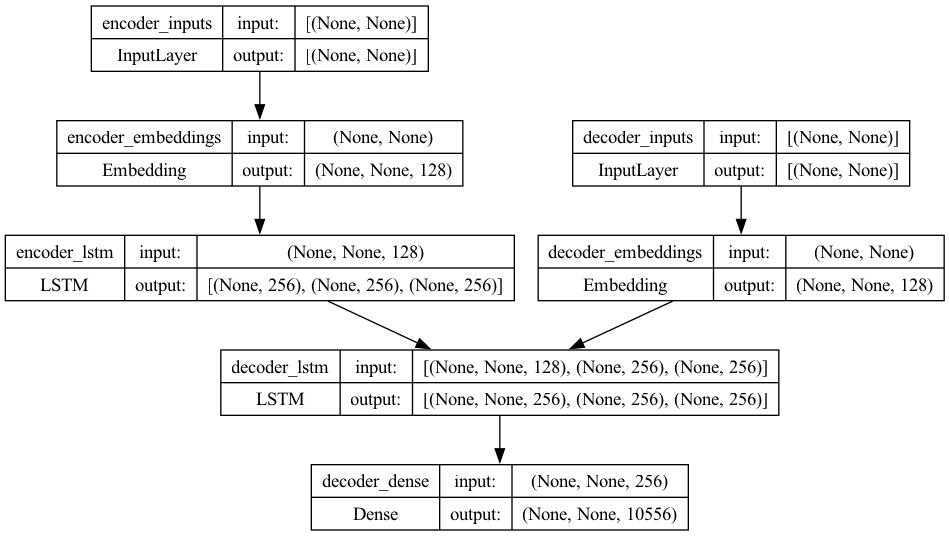

In [40]:
from keras.utils import plot_model
plot_model(model, to_file='hun_eng_seq2seq_nmt_no_attention.png', show_shapes=True, show_layer_names=True)

I personally found keeping the right matrix dimensions in mind more challenging and tricky than the theoretical concepts. So here are the dimensions we're working with in this training model.

In [41]:
print('encoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len)))
print()
print('encoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len), (batch_size, max_encoding_len, embedding_dim)))
print()
print('encoder_lstm layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_encoding_len, embedding_dim), [(batch_size, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print()
print('decoder_inputs layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len)))
print()
print('decoder_embeddings layer\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len), (batch_size, max_decoding_len, embedding_dim)))
print()
print('decoder_lstm layer\n input dimension {}\n output dimension: {}'.format([(batch_size, max_decoding_len, embedding_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)], [(batch_size, max_decoding_len, hidden_dim), (batch_size, hidden_dim), (batch_size, hidden_dim)]))
print()
print('decoder_dense layer(softmax)\n input dimension {}\n output dimension: {}'.format((batch_size, max_decoding_len, hidden_dim), (batch_size, max_decoding_len, target_vocab_size)))

encoder_inputs layer
 input dimension (32, 37)
 output dimension: (32, 37)

encoder_embeddings layer
 input dimension (32, 37)
 output dimension: (32, 37, 128)

encoder_lstm layer
 input dimension (32, 37, 128)
 output dimension: [(32, 256), (32, 256), (32, 256)]


decoder_inputs layer
 input dimension (32, 34)
 output dimension: (32, 34)

decoder_embeddings layer
 input dimension (32, 34)
 output dimension: (32, 34, 128)

decoder_lstm layer
 input dimension [(32, 34, 128), (32, 256), (32, 256)]
 output dimension: [(32, 34, 256), (32, 256), (32, 256)]

decoder_dense layer(softmax)
 input dimension (32, 34, 256)
 output dimension: (32, 34, 10556)


Because this model takes a while to train, we're using model checkpoints to save the weights after every epoch. This way, if something goes wrong with our system during training, we can reload the last set of weights from the checkpoint, and resume training from there.
https://keras.io/api/callbacks/model_checkpoint/

In [42]:
# Saving this to a folder on my local machine.
filepath="./HunEngNMTNoAttention/training1/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)

We'll also use **early stopping** as we have recently.
<br><br>
The *fit* method below is commmented out because I trained the model ahead of time and saved it. I also saved the tokenizers.
<br><br>
If you want to train it yourself, feel free to uncomment and execute it. Keep in mind that because of the random weight initialization, your trained model's output will likely differ from mine.

In [43]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# history = model.fit([padded_train_encoder_inputs, padded_train_decoder_inputs], padded_train_decoder_targets,
#                      batch_size=batch_size,
#                      epochs=epochs,
#                      validation_data=([padded_val_encoder_inputs, padded_val_decoder_inputs], padded_val_decoder_targets),
#                      callbacks=[cp_callback, es_callback])

The model I previously trained exited at epoch 12 with these metrics.

> Epoch 12: saving model to ./HunEngNMTNoAttention/training1/cp.ckpt
2771/2771 [==============================] - 105s 38ms/step
- loss: 0.1315 - sparse_categorical_accuracy: 0.8450
- val_loss: 0.3996 - val_sparse_categorical_accuracy: 0.6832



If you choose to train your own model, the following functions save the model and tokenizers.

In [ ]:
###### Save the model.
# model.save('hun_eng_s2s_nmt_no_attention')


###### Zip and download the model.
# !zip -r ./hun_eng_s2s_nmt_no_attention.zip ./hun_eng_s2s_nmt_no_attention
# files.download("./hun_eng_s2s_nmt_no_attention.zip")


###### Save the tokenizers as JSON files. The resulting files can be downloaded by left-clicking on them.
# source_tokenizer_json = source_tokenizer.to_json()
# with io.open('source_tokenizer.json', 'w', encoding='utf-8') as f:
#   f.write(json.dumps(source_tokenizer_json, ensure_ascii=False))

# target_tokenizer_json = target_tokenizer.to_json()
# with io.open('target_tokenizer.json', 'w', encoding='utf-8') as f:
#   f.write(json.dumps(target_tokenizer_json, ensure_ascii=False))

At this point, we can retrieve the saved model and saved tokenizers and try them on the **test** dataset.

In [44]:
# Retrieve the tokenizers.
!wget https://github.com/futuremojo/nlp-demystified/raw/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_tokenizers.zip

--2024-01-21 13:44:28--  https://github.com/futuremojo/nlp-demystified/raw/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_tokenizers.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_tokenizers.zip [following]
--2024-01-21 13:44:28--  https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_tokenizers.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1429081 (1.4M) [application/zip]
Saving to: ‘hun_eng_s2s_nmt_no_attention_tokenizers.zi

In [45]:
!unzip -o hun_eng_s2s_nmt_no_attention_tokenizers.zip

Archive:  hun_eng_s2s_nmt_no_attention_tokenizers.zip
  inflating: target_tokenizer.json   
  inflating: source_tokenizer.json   


The tokenizers can be loaded using the *tokenizer_from_json* method.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/tokenizer_from_json

In [46]:
with open('source_tokenizer.json') as f:
    data = json.load(f)
    source_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

with open('target_tokenizer.json') as f:
    data = json.load(f)
    target_tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [47]:
# Retrieve the model.
!wget https://github.com/futuremojo/nlp-demystified/raw/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_model.zip

--2024-01-21 13:44:46--  https://github.com/futuremojo/nlp-demystified/raw/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_model.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_model.zip [following]
--2024-01-21 13:44:46--  https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/models/nmt_no_attention/hun_eng_s2s_nmt_no_attention_model.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99022817 (94M) [application/zip]
Saving to: ‘hun_eng_s2s_nmt_no_attention_model.zip’

hun_eng_s2s_nmt_

In [48]:
!unzip -o hun_eng_s2s_nmt_no_attention_model.zip

Archive:  hun_eng_s2s_nmt_no_attention_model.zip
   creating: hun_eng_s2s_nmt_no_attention/
   creating: hun_eng_s2s_nmt_no_attention/variables/
  inflating: hun_eng_s2s_nmt_no_attention/variables/variables.index  
  inflating: hun_eng_s2s_nmt_no_attention/variables/variables.data-00000-of-00001  
  inflating: hun_eng_s2s_nmt_no_attention/saved_model.pb  
   creating: hun_eng_s2s_nmt_no_attention/assets/
  inflating: hun_eng_s2s_nmt_no_attention/keras_metadata.pb  


In [49]:
# Load the model.
model = tf.keras.models.load_model('hun_eng_s2s_nmt_no_attention')

2024-01-21 13:45:13.229295: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-01-21 13:45:13.407741: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-01-21 13:45:13.927082: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-01-21 13:45:13.944137: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-01-21 13:45:13.972938: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _ou

The *test* dataset contains sentences (and most certainly words) unseen by the model.

In [50]:
# Retrieve the test dataset.
!wget https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_test.txt

--2024-01-21 13:47:35--  https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/datasets/hun_eng_pairs/hun_eng_pairs_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646226 (631K) [text/plain]
Saving to: ‘hun_eng_pairs_test.txt’

hun_eng_pairs_test. 100%[===================>] 631.08K  --.-KB/s    in 0.09s   

2024-01-21 13:47:35 (6.97 MB/s) - ‘hun_eng_pairs_test.txt’ saved [646226/646226]



In [51]:
with open('hun_eng_pairs_test.txt') as file:
  test = [line.rstrip() for line in file]

In [52]:
test[:3]

['Abbahagyhatom, ha zavar.<sep>If it bothers you, I can stop doing this.',
 'Nős voltam.<sep>I was married.',
 'Ez a zene az idegeire megy.<sep>That music gets on his nerves.']

In [53]:
# Preprocess test dataset
padded_test_encoder_inputs, padded_test_decoder_inputs, padded_test_decoder_targets = process_dataset(test)

In [54]:
# Evaluate the model on the test set.
model.evaluate([padded_test_encoder_inputs, padded_test_decoder_inputs], padded_test_decoder_targets)

326/326 [==============================] - 22s 64ms/step - loss: 1.8110 - sparse_categorical_accuracy: 0.6832


[1.8109676837921143, 0.6832318902015686]

Our training model uses teacher forcing, but that won't be the case for inference. So we'll take the trained layers from our training model, and create **separate**, stand-alone encoder and decoder models. This will give us much greater control over how the output is created as we'll see. (e.g. feeding the current output as the input to the next time step).

In [55]:
# These are the layers of our trained model.
[layer.name for layer in model.layers]

['encoder_inputs',
 'decoder_inputs',
 'encoder_embeddings',
 'decoder_embeddings',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

Creating a stand-alone encoder is just a matter of retrieving the trained layers by name and re-creating the graph.

The major difference here is the last line where we're calling *tf.keras.Model* to create a stand-alone encoder with *encoder_inputs* as the input and *encoder_states* as the output.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model#get_layer

In [56]:
encoder_inputs = model.get_layer('encoder_inputs').input

encoder_embedding_layer = model.get_layer('encoder_embeddings')
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = model.get_layer('encoder_lstm')

_, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embeddings)

encoder_states = [encoder_state_h, encoder_state_c]

# Our stand-alone encoder model. encoder_inputs is the input to the encoder,
# and encoder_states is the expected output.
encoder_model_no_attention = tf.keras.Model(encoder_inputs, encoder_states)

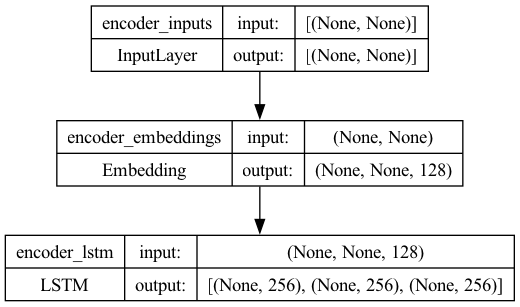

In [57]:
plot_model(encoder_model_no_attention, to_file='encoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

Creating the decoder is similar. The major difference here is that there are two additional inputs to the decoder representing its LSTM hidden state (*decoder_input_state_h*) and cell state (*decoder_input_state_c*), respectively.
<br><br>
They are there because the encoder and decoder are now separate models, so we'll manually take the encoder's output (its final states) and use them as the decoder's initial state. From there, at each time step, we'll take the decoder's state outputs and feed them to the next time step.
<br><br>
The stand-alone decoder now takes as input:
- Either the '\<sos\>' token (at the beginning) or the output from the previous timestep. Either way, it'll now take only one token at a time.
- Hidden and cell states, either from the encoder initially or from the decoder's last time step.
<br>

And it outputs a probability distribution for the current output, and new hidden and cell states.

In [58]:
decoder_inputs = model.get_layer('decoder_inputs').input

decoder_embedding_layer = model.get_layer('decoder_embeddings')
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# Inputs to represent the decoder's LSTM hidden and cell states. We'll populate
# these manually using the encoder's output for the initial state.
decoder_input_state_h = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_h')
decoder_input_state_c = tf.keras.Input(shape=(hidden_dim,), name='decoder_input_state_c')
decoder_input_states = [decoder_input_state_h, decoder_input_state_c]

decoder_lstm = model.get_layer('decoder_lstm')

decoder_sequence_outputs, decoder_output_state_h, decoder_output_state_c = decoder_lstm(
    decoder_embeddings, initial_state=decoder_input_states
)

# Update hidden and cell states for the next time step.
decoder_output_states = [decoder_output_state_h, decoder_output_state_c]

decoder_dense = model.get_layer('decoder_dense')
y_proba = decoder_dense(decoder_sequence_outputs)

decoder_model_no_attention = tf.keras.Model(
    [decoder_inputs] + decoder_input_states,
    [y_proba] + decoder_output_states
)

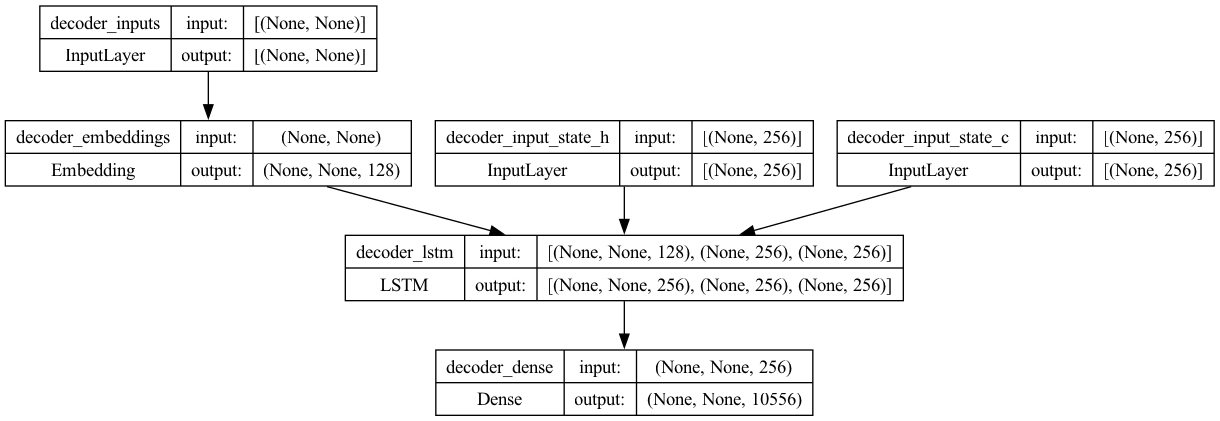

In [59]:
plot_model(decoder_model_no_attention, to_file='decoder_model_no_attention_plot.png', show_shapes=True, show_layer_names=True)

The method below translates a sentence from the source language to the target language. It encodes the source sentence as usual, then feeds the encoder's state outputs and the \<sos\> token into the decoder.
<br><br>
The decoder's outputs (the resulting word and its hidden/cell states) are then fed back to the decoder at the next time step. This continues until either a max word limit is reached or an \<eos\> token is generated.

In [88]:
def translate_without_attention(sentence: str,
                                source_tokenizer, encoder,
                                target_tokenizer, decoder,
                                max_translated_len = 30):

  # Vectorize the source sentence and run it through the encoder.
  input_seq = source_tokenizer.texts_to_sequences([sentence])

  # Get the tokenized sentence to see if there are any unknown tokens.
  tokenized_sentence = source_tokenizer.sequences_to_texts(input_seq)

  states = encoder.predict(input_seq)

  current_word = '<sos>'
  decoded_sentence = []

  while len(decoded_sentence) < max_translated_len:

    # Set the next input word for the decoder.
    target_seq = np.zeros((1,1)) # 1 x 1 array bc batch of 1 containing sequence of length 1 (one word at a time)
    target_seq[0, 0] = target_tokenizer.word_index[current_word] #populate with numeric index form of current word (so that embedding layer can be used)
    
    print([target_seq] + states)
    
    # Determine the next word.
    target_y_proba, h, c = decoder.predict([target_seq] + states) # [target_seq] + states will be of form (target int, h, c)
    target_token_index = np.argmax(target_y_proba[0, -1, :])
    current_word = target_tokenizer.index_word[target_token_index]

    if (current_word == '<eos>'):
      break

    decoded_sentence.append(current_word)
    states = [h, c] #hidden and cell states from current timestep become input to next timestep

  return tokenized_sentence[0], ' '.join(decoded_sentence) #return tokenized source sentence and the translation


To test it out, we'll sample a bunch of sentences from the *test* dataset and translate them.

In [89]:
# random.seed is just here to re-create results.
random.seed(1)
sentences = random.sample(test, 15)
sentences

['Csinálom.<sep>I got it.',
 'Mondd el nekem.<sep>Let me know.',
 'Ritkán járok oda.<sep>I rarely go there.',
 "Mi a döntésed?<sep>What's your decision?",
 "Hol van a legközelebbi étterem?<sep>Where's the closest restaurant?",
 'Mégis csak van egy megoldás.<sep>There is a solution though.',
 'Csak pár diák maradt az osztályteremben.<sep>There were few students left in the classroom.',
 'Nagyra értékelem a segítségedet ebben.<sep>I appreciate your help on this.',
 'Ez az utolsó vonat.<sep>This is the last train.',
 'Milyen gyakran jönnek a buszok?<sep>How often do buses come?',
 "A boldogság nem tart örökké.<sep>Happiness doesn't last forever.",
 "Azért vagyok itt, hogy bocsánatot kérjek.<sep>I'm here to apologize.",
 "Tom szörnyű szakács, ugye?<sep>Tom is a terrible cook, isn't he?",
 "Gondolod, hogy ma esni fog?<sep>Do you think it'll rain today?",
 'Tom ismeri a járást.<sep>Tom knows the way.']

In [90]:
def translate_sentences(sentences, translation_func, source_tokenizer, encoder,
                        target_tokenizer, decoder):
  translations = {'Tokenized Original': [], 'Reference': [], 'Translation': []}

  for s in sentences:
    source, target = s.split(SEPARATOR)
    source = preprocess_sentence(source)
    tokenized_sentence, translated = translation_func(source, source_tokenizer, encoder,
                                                      target_tokenizer, decoder)

    translations['Tokenized Original'].append(tokenized_sentence)
    translations['Reference'].append(target)
    translations['Translation'].append(translated)

  return translations

We'll load the results into a Pandas **DataFrame** for easier viewing.<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [91]:
translations_no_attention = pd.DataFrame(translate_sentences(sentences, translate_without_attention,
                                                             source_tokenizer, encoder_model_no_attention,
                                                             target_tokenizer, decoder_model_no_attention))
translations_no_attention

1/1 [==============================] - 0s 19ms/step


[array([[2.]]), array([[-9.82242916e-03, -2.39060849e-01, -7.80140013e-02,
        -2.00750362e-02,  2.03654170e-01, -8.42813790e-01,
         2.19114646e-02, -1.31727740e-01, -9.98386964e-02,
        -2.71359086e-01, -4.08442020e-01, -1.10070877e-01,
        -4.73386019e-01, -3.24085355e-01,  4.81317937e-01,
         3.12492326e-02, -1.59460813e-01, -2.38291863e-02,
        -2.47989088e-01, -7.03164697e-01, -1.08030677e-01,
         4.83435346e-03, -5.79082370e-01,  1.56420961e-01,
        -5.64560831e-01,  4.11096066e-01,  8.69879276e-02,
        -1.07724339e-01,  6.61924243e-01, -1.56457778e-02,
        -3.18001479e-01, -5.63200355e-01, -2.08084229e-02,
        -4.17104125e-01, -6.54750541e-02,  3.44183184e-02,
        -6.72808588e-02,  2.37914128e-03, -1.12488428e-02,
         5.87939084e-01,  5.53634576e-03,  2.86946651e-02,
        -6.83835521e-02,  3.67270112e-01,  1.89548537e-01,
         5.93892224e-02,  5.85906923e-01, -8.69413689e-02,
         1.33608565e-01, -2.47415267e-02

Tokenized Original  \
0                                    csinalom .   
1                              mondd el nekem .   
2                            ritkan jarok oda .   
3                               mi a dontesed ?   
4              hol van a legkozelebbi etterem ?   
5                 megis csak van egy megoldas .   
6     csak par diak maradt az osztalyteremben .   
7       nagyra ertekelem a segitsegedet ebben .   
8                          ez az utolso vonat .   
9              milyen gyakran jonnek a buszok ?   
10                a boldogsag nem tart orokke .   
11  azert vagyok itt , hogy bocsanatot kerjek .   
12                 tom szornyu szakacs , ugye ?   
13                gondolod , hogy ma esni fog ?   
14                         tom ismeri a <unk> .   

                                         Reference  \
0                                        I got it.   
1                                     Let me know.   
2                               I rarely go there.   
3                            What's your decision?   
4                  Where's the closest restaurant?   
5                      There is a solution though.   
6   There were few students left in the classroom.   
7                  I appreciate your help on this.   
8                          This is the last train.   
9                         How often do buses come?   
10                 Happiness doesn't last forever.   
11                          I'm here to apologize.   
12               Tom is a terrible cook, isn't he?   
13                  Do you think it'll rain today?   
14                              Tom knows the way.   

                                 Translation  
0                             i'm doing it .  
1                                  tell me .  
2                        i seldom go there .  
3                    what is your decision ?  
4           where's the nearest restaurant ?  
5                there's only one solution .  
6   a few students remained in the library .  
7           i appreciate your help with me .  
8                       this train is last .  
9              how often do the buses come ?  
10                 the website is not open .  
11                       i'm here to start .  
12      tom is a terrible musician , is he ?  
13           do you think it'll rain today ?  
14                     tom knows his stuff .

So performance here tends to be mixed with a few translations which are off, a few which match the reference exactly, and a few interesting ones where the translation doesn't match the reference but conveys the same idea. But overall, pretty good.
<br><br>
There are several limitations we're working with:
- Hungarian is a difficult language because of its flexible structure and high expressiveness. The conjugation style leads to several English words often mapping to one word in Hungarian. Even Google Translate tends to have a high error rate with Hungarian.
- This is a small dataset and to build something robust requires much more data. It also isn't very wide and diverse.
- We're using a simple model with one LSTM for the encoder, and one LSTM for the decoder. In contrast, when Google Translate was still fully recurrence-based, it used an eight-layer LSTM for the encoder, and an eight-layer LSTM for the decoder (though in this case, I still think the data is the primary limitation).
- Translation remains a tricky and hard problem. For examples of issues that arise in translation, check out the video from Rasa in the *References* section at the end of the notebook.
<br><br>
Still, we managed to get some decent and interesting results with a simple approach. Next, let's learn how to add an attention layer.

# Recurrence-based Seq2Seq Neural Machine Translation **WITH** Luong Attention

All the preprocessing steps and tokenizers we already have can carry over here.

This time around, we'll decouple the encoder and decoder from the beginning (i.e. won't have to build separate models for training and inference). And rather than using the **Functional API**, we'll use **subclassing** instead.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model<br>
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In the constructor, we declare our layers. The encoder flow remains much the same. The big difference with this encoder's LSTM layer is that it has *return_sequences* set to *True*. This means the encoder will now output a hidden state at each time step which will be used by the attention mechanism. And there is no masking because masks don't flow through custom layers (such as the attention mechanism), so we'll handle the masking ourselves in a custom loss function.
<br><br>
The overriden *call* method contains the operations of our model. i.e. it describes how the model should turns inputs into outputs.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model#call

In [92]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()

        # No masking here. We'll handle it ourselves.
        self.embedding = layers.Embedding(source_vocab_size,
                                          embedding_dim,
                                          name='encoder_embedding_layer')

        # return_sequences is set to True this time.
        self.lstm = layers.LSTM(hidden_dim,
                                return_sequences=True,
                                return_state=True,
                                name='encoder_lstm')

    def call(self, input):
        embeddings = self.embedding(input)

        # output_seq will hold the encoder's hidden states from each time step.
        output_seq, state_h, state_c = self.lstm(embeddings)

        return output_seq, state_h, state_c

We can get a sense of the encoder's outputs by instantiating a dummy encoder and passing it some input.

In [93]:
test_encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)

The encoder will receive a batch of sequences.

In [94]:
test_encoder_batch = padded_train_encoder_inputs[:3]
print(test_encoder_batch.shape)
test_encoder_batch

(3, 37)


array([[1395,   91,    4,   27, 1080,   10,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 153,   56,  145,   17,  152,    3, 7232,    4,   45, 1670,   44,
          23,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [1026,    3, 8933,   10,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

The encoder's overriden *call* method is invoked by *\_\_call\_\_* (dunder method), which is why we're executing the encoder instance as if it's a function.<br>
https://stackoverflow.com/questions/9663562/what-is-the-difference-between-init-and-call<br>
https://docs.python.org/3/reference/datamodel.html#object.__call__

In [95]:
test_encoder_outputs, state_h, state_c = test_encoder(test_encoder_batch)

In [96]:
print(test_encoder_outputs.shape)
print(state_h.shape)
print(state_c.shape)

(3, 37, 256)
(3, 256)
(3, 256)


Before we create the attention class, let's walk through a simple example of multiplicative (dot product) attention. The one we'll eventually create will be almost identical.

Suppose the following is the sequence of hidden states from the encoder after processing a single four-token sentence. Each hidden state is of dimension three.

In [97]:
# Sample encoder LSTM output for single sequence of length 4.
encoder_out = tf.constant([[1., 2., 3.],
                           [2., 3., 4.],
                           [3., 4., 5.],
                           [4., 5. ,6.]])

In [98]:
print('encoder_out shape: {}'.format(encoder_out.shape))
print('Number of timesteps: {}'.format(encoder_out.shape[0]))
print('Number of hidden dimensions: {}'.format(encoder_out.shape[1]))

encoder_out shape: (4, 3)
Number of timesteps: 4
Number of hidden dimensions: 3


And suppose the following is the hidden state from the decoder at a particular time step.

In [99]:
# Sample decoder LSTM output for a single timestep.
decoder_out = tf.constant([[1., 3., 5.]])

In [100]:
print('decoder_out shape: {}'.format(decoder_out.shape))
print('Number of timesteps: {}'.format(decoder_out.shape[0]))
print('Number of hidden dimensions: {}'.format(decoder_out.shape[1]))

decoder_out shape: (1, 3)
Number of timesteps: 1
Number of hidden dimensions: 3


In order to get the attention scores, we need to perform a dot product between the decoder hidden state and the encoder hidden states. To do that, the encoder hidden states need to be transposed.

In [101]:
tf.transpose(encoder_out)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [3., 4., 5., 6.]], dtype=float32)>

The *tf.matmul* function can perform the transpose and the dot product in one step to yield the attention scores.<br>
https://www.tensorflow.org/api_docs/python/tf/linalg/matmul

In [102]:
attention_scores = tf.matmul(decoder_out, encoder_out, transpose_b=True)
print(attention_scores)

tf.Tensor([[22. 31. 40. 49.]], shape=(1, 4), dtype=float32)


We can then apply a softmax to the attention scores to get the attention weights.<br>
https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax

In [103]:
attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
print(attention_weights)

tf.Tensor([[1.8792968e-12 1.5228101e-08 1.2339458e-04 9.9987662e-01]], shape=(1, 4), dtype=float32)


Finally, we can create the context vector using the attention weights and the encoder outputs. Once we have our context vector we can use it in our decoder. Refer to this module's video/slides for a refresher if needed.


In [104]:
context = tf.matmul(attention_weights, encoder_out)
print(context)

tf.Tensor([[3.9998767 4.9998765 5.999877 ]], shape=(1, 3), dtype=float32)


The attention class below follows the same steps. The only difference is the encoder outputs go through a dense layer first.
<br><br>
For input, the attention class takes in all the encoder hidden states and the current decoder hidden state. For output, it returns the attention weights (which could be useful for other purposes) and the context vector.

In [105]:
class LuongAttention(tf.keras.Model):
  def __init__(self, hidden_dim):
    super(LuongAttention, self).__init__()

    self.w = layers.Dense(hidden_dim, name='encoder_outputs_dense')

  def call(self, inputs):
    encoder_output_seq, decoder_output = inputs
    z = self.w(encoder_output_seq)
    attention_scores = tf.matmul(decoder_output, z, transpose_b=True)
    attention_weights = tf.keras.activations.softmax(attention_scores, axis=-1)
    context = tf.matmul(attention_weights, encoder_output_seq)

    return attention_weights, context


The decoder remains mostly the same except:
1. The embedding layer doesn't have masking.
2. There's an additional attention step in the flow.
3. The combined context and decoder output vector goes through a dense layer *w*. Refer to this module's video/slides if a refresher is needed.
4. The final dense layer has no softmax activation. Rather, we'll calculate the loss directly on the logits.
<br>

For inputs, the decoder receives:
1. the token(s) for the current step. During training with teacher forcing, that would be the next expected token(s). During inference, that would be the token(s) generated from the last time step.
2. all the encoder's hidden states.
3. whatever the decoder should take as its current hidden and cell states.
<br>

For outputs, the decoder returns the:
1. logits.
2. last LSTM hidden and cell states.
3. attention weights.

In [106]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Decoder, self).__init__()

    self.embedding_layer = layers.Embedding(vocab_size,
                                            embedding_dim,
                                            name='decoder_embedding_layer')

    self.lstm = layers.LSTM(hidden_dim,
                            return_sequences=True,
                            return_state=True,
                            name='decoder_lstm')

    self.attention = LuongAttention(hidden_dim)

    self.w = tf.keras.layers.Dense(hidden_dim, activation='tanh', name='attended_outputs_dense')

    self.dense = layers.Dense(vocab_size, name='decoder_dense')


  def call(self, inputs):
    decoder_input, encoder_output_seq, lstm_state = inputs
    embeddings = self.embedding_layer(decoder_input)

    decoder_output, state_h, state_c = self.lstm(embeddings, initial_state=lstm_state)

    weights, context = self.attention([encoder_output_seq, decoder_output])

    decoder_output_with_attention = self.w(tf.concat(
        [tf.squeeze(context, 1), tf.squeeze(decoder_output, 1)], -1))

    logits = self.dense(decoder_output_with_attention)

    return logits, state_h, state_c, weights

We can get a sense of the decoder's inputs and outputs for a single training time step with a test.

In [107]:
test_decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)

Suppose this is a batch of input sequences for the decoder (the sequences used for teacher forcing)...

In [108]:
test_decoder_batch = padded_train_decoder_inputs[:3]
print(test_decoder_batch.shape)
test_decoder_batch

(3, 34)


array([[  2,   5,  23, 306,  28,   7, 151,   4,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  25,  55, 117, 144,  33,   7,  35, 139, 794,   4,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0],
       [  2, 105, 306,  17,  24, 225,   4,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

...and let's say we're currently on the second timestep (index 1).These would be the next inputs to the decoder for each sequence in the batch:

In [109]:
test_decoder_batch[:, 1]

array([  5,  25, 105], dtype=int32)

But we need to modify this to be *three sequences of one element* which we can do with *expand_dims*.<br>
https://www.tensorflow.org/api_docs/python/tf/expand_dims


In [110]:
next_decoder_inputs = tf.expand_dims(test_decoder_batch[:, 1], 1)
next_decoder_inputs

<tf.Tensor: shape=(3, 1), dtype=int32, numpy=
array([[  5],
       [ 25],
       [105]], dtype=int32)>

In [111]:
# Initial values for state_h and state_c are from the encoder.
test_decoder_logits, state_h, state_c, test_decoder_weights = test_decoder(
    [
      next_decoder_inputs,
      test_encoder_outputs,
      [state_h, state_c]
    ])

In [112]:
print(test_decoder_logits.shape) #logits for next word
print(test_decoder_weights.shape) #attention weights

(3, 10556)
(3, 1, 37)


We're going to use a custom loss function because our sequences contain padding, and we don't want predictions on padding to contribute to the loss.
<br><br>
This custom loss function is simply a wrapper around a **sparse categorical crossentropy** loss, but with a mask of 1s and 0s. Any target element of 0 (i.e. a padding value) will get a mask value of 0, everything else will get a mask of 1, and only target values corresponding to a mask value of 1 will be used for loss calculation.
<br><br>
Refer to this page to get a sense of what the *targets* and *logits* parameters look like:<br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [113]:
def loss_func(targets, logits):
  ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  mask = tf.cast(tf.math.not_equal(targets, 0), tf.float32) #mask as long as targets, wherever targets is 0, mask is 0, otherwise set to 1

  return ce_loss(targets, logits, sample_weight=mask) #pass mask to CE function, along with targets and logits, this way target values with 0 are not considered in loss calculation

We'll use Tensorflow's **Dataset** to batch our data like we did in the previous model on RNNs.<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch



In [114]:
dataset = tf.data.Dataset.from_tensor_slices((padded_train_encoder_inputs,
                                              padded_train_decoder_inputs,
                                              padded_train_decoder_targets)).batch(batch_size, drop_remainder=True)

Finally, this is our training function. It'll be called for each batch of data.
<br><br>
*train_step* doesn't have to be in a class, but by putting it inside a *Model* subclass, we can leverage the *fit* method rather than writing our own training loop.
<br><br>
*train_step* is an overridden method called by the *fit* method.<br>
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
<br><br>
Any operation within the _GradientTape_ context is recorded, and the variables involved are watched. We can then have Tensorflow's autodiff calculate the gradients of the variables with respect to the loss, and backpropagate it through the operations involved.
https://www.tensorflow.org/api_docs/python/tf/GradientTape<br>
https://www.tensorflow.org/guide/autodiff
<br><br>
*train_step* is wrapped in a *@tf.function* annotation for a bit of a performance boost.<br>
https://www.tensorflow.org/api_docs/python/tf/function<br>
https://www.tensorflow.org/guide/function<br>


In [115]:
class TranslatorTrainer(tf.keras.Model):
  def __init__(self, encoder, decoder):
    super(TranslatorTrainer, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  # This method will be called by model.fit for each batch.
  @tf.function
  def train_step(self, inputs):
      loss = 0.

      encoder_input_seq, decoder_input_seq, decoder_target_seq = inputs

      with tf.GradientTape() as tape:
          encoder_output_seq, state_h, state_c = self.encoder(encoder_input_seq)

          # We need to create a loop to iterate through the target sequences
          for i in range(decoder_target_seq.shape[1]):

              # Input to the decoder must have shape of (batch_size, length)
              # so we need to expand one dimension (just like in the previous example).
              next_decoder_input = tf.expand_dims(decoder_input_seq[:, i], 1)
              logits, state_h, state_c, _ = self.decoder(
                  [next_decoder_input, encoder_output_seq, (state_h, state_c)])

              # The loss is now accumulated through the whole batch
              loss += self.loss(decoder_target_seq[:, i], logits)

      # Update the parameters and the optimizer
      variables = encoder.trainable_variables + decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      self.optimizer.apply_gradients(zip(gradients, variables))

      return {'loss': loss / decoder_target_seq.shape[1]}

In [116]:
encoder = Encoder(source_vocab_size, embedding_dim, hidden_dim)
decoder = Decoder(target_vocab_size, embedding_dim, hidden_dim)
optimizer = tf.keras.optimizers.Adam()

translator_trainer = TranslatorTrainer(encoder, decoder)
translator_trainer.compile(optimizer=optimizer, loss=loss_func)

We now have everything to train our encoder and decoder.
<br><br>
The following *fit* call is commented out because the encoder and decoder were trained prior to save time. If you want to train them yourself, feel free to uncomment and execute the method.<br><br>
**Note**: Because of the random weight initialization, your trained model's output will likely differ from mine.

In [117]:
epochs = 12
# translator_trainer.fit(dataset, epochs=epochs)

Functions to save, zip, and download the weights of the trained encoder and decoder.

In [ ]:
# encoder.save_weights('attention_encoder_weights_with_dropout_ckpt')
# decoder.save_weights('attention_decoder_weights_with_dropout_ckpt')

# !zip -r ./attention_weights.zip ./attention_weights

# files.download('./attention_weights.zip')

We'll download and load the previously trained attention-based encoder and decoder.

In [118]:
!wget https://github.com/futuremojo/nlp-demystified/raw/main/models/nmt_with_attention/attention_weights.zip
!unzip -o attention_weights.zip

--2024-01-21 14:52:28--  https://github.com/futuremojo/nlp-demystified/raw/main/models/nmt_with_attention/attention_weights.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/models/nmt_with_attention/attention_weights.zip [following]
--2024-01-21 14:52:28--  https://raw.githubusercontent.com/futuremojo/nlp-demystified/main/models/nmt_with_attention/attention_weights.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36984175 (35M) [application/zip]
Saving to: ‘attention_weights.zip’

attention_weights.z 100%[===================>]  35.27M  4.13MB/s    in 8.0s   

In [119]:
encoder.load_weights('attention_weights/attention_encoder_weights_ckpt')
decoder.load_weights('attention_weights/attention_decoder_weights_ckpt')

The *translate_with_attention* method is similar to the method without attention, except it involves padding since the LSTMs didn't use masking, and also using the encoder's hidden states.

In [120]:
def translate_with_attention(sentence: str,
                             source_tokenizer, encoder,
                             target_tokenizer, decoder,
                             max_translated_len = 30):
    input_seq = source_tokenizer.texts_to_sequences([sentence])
    tokenized = source_tokenizer.sequences_to_texts(input_seq)

    input_seq = pad_sequences(input_seq, maxlen=max_encoding_len, padding='post') #padding here
    encoder_output, state_h, state_c  = encoder.predict(input_seq)

    current_word = '<sos>'
    decoded_sentence = []

    while len(decoded_sentence) < max_translated_len:
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = target_tokenizer.word_index[current_word]

        logits, state_h, state_c, _ = decoder.predict([target_seq, encoder_output, (state_h, state_c)])
        current_token_index = np.argmax(logits[0]) #uses logits rather than probability distribution

        current_word = target_tokenizer.index_word[current_token_index]

        if (current_word == '<eos>'):
          break

        decoded_sentence.append(current_word)

    return tokenized[0], ' '.join(decoded_sentence)

We'll translate the same randomly sampled sentences from before and compare the results against the translations without attention.

In [121]:
shorter_translations_w_attention = pd.DataFrame(translate_sentences(sentences, translate_with_attention,
                                                                    source_tokenizer, encoder,
                                                                    target_tokenizer, decoder))

1/1 [==============================] - ETA: 0s

W0000 00:00:1705866838.876045       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 12ms/step


In [122]:
shorter_translations_w_attention.rename(columns={'Translation': 'Translation W/ Attention'}, inplace=True)
shorter_translations_w_attention['Translation W/O Attention'] = translations_no_attention['Translation']
shorter_translations_w_attention

Tokenized Original  \
0                                    csinalom .   
1                              mondd el nekem .   
2                            ritkan jarok oda .   
3                               mi a dontesed ?   
4              hol van a legkozelebbi etterem ?   
5                 megis csak van egy megoldas .   
6     csak par diak maradt az osztalyteremben .   
7       nagyra ertekelem a segitsegedet ebben .   
8                          ez az utolso vonat .   
9              milyen gyakran jonnek a buszok ?   
10                a boldogsag nem tart orokke .   
11  azert vagyok itt , hogy bocsanatot kerjek .   
12                 tom szornyu szakacs , ugye ?   
13                gondolod , hogy ma esni fog ?   
14                         tom ismeri a <unk> .   

                                         Reference  \
0                                        I got it.   
1                                     Let me know.   
2                               I rarely go there.   
3                            What's your decision?   
4                  Where's the closest restaurant?   
5                      There is a solution though.   
6   There were few students left in the classroom.   
7                  I appreciate your help on this.   
8                          This is the last train.   
9                         How often do buses come?   
10                 Happiness doesn't last forever.   
11                          I'm here to apologize.   
12               Tom is a terrible cook, isn't he?   
13                  Do you think it'll rain today?   
14                              Tom knows the way.   

                             Translation W/ Attention  \
0                                      i'm doing it .   
1                                           tell me .   
2                                 i rarely go there .   
3                             what is your decision ?   
4                       where's the nearest package ?   
5                          there is no one solution .   
6   there were only a few students left in the cla...   
7                            i appreciate your help .   
8                            this is the last train .   
9                       how often do the buses come ?   
10                 happiness is not forever forever .   
11                            i'm here to apologize .   
12                tom is a terrible cook , isn't he ?   
13            do you think it's going to rain today ?   
14                               tom knows his mind .   

                   Translation W/O Attention  
0                             i'm doing it .  
1                                  tell me .  
2                        i seldom go there .  
3                    what is your decision ?  
4           where's the nearest restaurant ?  
5                there's only one solution .  
6   a few students remained in the library .  
7           i appreciate your help with me .  
8                       this train is last .  
9              how often do the buses come ?  
10                 the website is not open .  
11                       i'm here to start .  
12      tom is a terrible musician , is he ?  
13           do you think it'll rain today ?  
14                     tom knows his stuff .

In addition, let's take a look at results of translating the longest sentences in the training set to see how good they are.

In [123]:
pairs = train.copy()
pairs.sort(key=lambda s: len(s))
longer_sentences = pairs[-10:]
longer_sentences

['- Tegnap este mikor mentél aludni? - 4 órakor. - Micsoda? Mit csináltál olyan sokáig? - Telefonon beszélgettem a volt barátommal.<sep>"When\'d you go to sleep last night?" "4 o\'clock." "What? What were you doing up so late?" "Talking on the phone with my ex-boyfriend."',
 'Mi az öregség? Először a neveket felejted el, majd az arcokat, utána elfelejted felhúzni a cipzáradat, aztán elfelejted lehúzni.<sep>What is old age? First you forget names, then you forget faces, then you forget to pull your zipper up, then you forget to pull it down.',
 "Bár a Föld felületének csupán két százalékát borítják őserdők, ott él a világon fellelhető állat-, növény- és rovarfaj fele.<sep>Although rainforests make up only two percent of the earth's surface, over half the world's wild plant, animal and insect species live there.",
 "Amikor gyerek volt Tom, összegyűjtötte az apja cigarettacsikkjeit, míg elég nem lett a dohány, hogy sodorjon egy szál cigarettát magának.<sep>When Tom was a kid, he used to c

In [124]:
longer_translations_wo_attention = translate_sentences(longer_sentences, translate_without_attention,
                                                       source_tokenizer, encoder_model_no_attention,
                                                       target_tokenizer, decoder_model_no_attention)

1/1 [==============================] - 0s 27ms/step
[array([[2.]]), array([[-1.13205686e-02, -4.62741964e-02, -1.79338327e-03,
        -2.34358385e-02, -3.25179935e-01,  3.11028538e-03,
         7.20380247e-03, -9.81560647e-01,  4.41852301e-01,
         9.96629238e-01,  4.74824846e-01,  1.06823994e-02,
         9.38292980e-01, -3.36903006e-01,  5.78697383e-01,
         7.35773938e-04, -7.22697318e-01, -2.13617235e-01,
         1.74738809e-01, -8.62149417e-01, -2.43892806e-04,
         1.62603962e-03, -2.91358656e-03, -4.63097356e-03,
         7.70213902e-01,  9.90838230e-01,  6.85761511e-01,
         9.84095514e-01, -5.22837877e-01, -2.02155206e-02,
        -9.46251214e-01,  2.50599802e-01,  1.70101464e-01,
         9.34912562e-01, -1.38254766e-03, -9.23678160e-01,
         1.81527972e-01,  3.80722433e-03, -5.12696133e-05,
        -9.31280494e-01, -1.97694469e-02, -3.53477546e-03,
        -1.61432242e-03, -3.05392504e-01, -5.46980262e-01,
        -8.87238514e-03,  1.59841508e-01,  6.51

In [ ]:
longer_translations_with_attention = pd.DataFrame(translate_sentences(longer_sentences, translate_with_attention,
                                                                      source_tokenizer, encoder,
                                                                      target_tokenizer, decoder))
longer_translations_with_attention.rename(columns={'Translation': 'Translation W/ Attention'}, inplace=True)
longer_translations_with_attention['Translation W/O Attention'] = longer_translations_wo_attention['Translation']
longer_translations_with_attention

Ok, so clearly the encoder/decoder with attention gets further along before losing signal and it often manages to translate words later in the sentence.<br><br>
But still, there are clear limitiations. For one thing, we need *much* more data. For another, most industrial translation systems use more complex models. For example, Google's NMT system (when it was based entirely on LSTMs) used eight layers for both the encoder and decoder.<br><br>
But beyond that, we can use a more powerful model which we'll explore in the next module.

# Further Exploration
1. Download another translation collection from [Tatoeba](https://tatoeba.org/en/downloads) and try using a more complex model (e.g. with more layers) to see if you get better performance.
<br><br>
2. Seq2Seq is a general problem approach. Try turning a non-language sequence into another sequence. For example, turn simple arithmetic problems (e.g. 2 + 1 * 3) into its respective answer. Generating your own dataset for such a scenario is easy.
<br><br>
3. [BLEU](https://en.wikipedia.org/wiki/BLEU) is a popular metric for evaluating translation quality. Now that you know how BLEU works (see video/slides) and have a bunch of machine-generated translations along with their human-provided references, try calculating BLEU for the results.
<br><br>
4. Implement Beam Search.

# References

Challenges in machine tanslation from RASA:
https://www.youtube.com/watch?v=94K4LU_Pe8Y

Sequence to Sequence Learning with Neural Networks

https://arxiv.org/abs/1409.3215


Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation
https://arxiv.org/abs/1406.1078


Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation
- 8 encoder and decoder layers
- Uses attention mechanism

 https://arxiv.org/abs/1609.08144




Neural Machine Translation by Jointly Learning to Align and Translate
 https://arxiv.org/abs/1409.0473


Effective Approaches to Attention-based Neural Machine Translation
https://arxiv.org/abs/1508.04025
